In [2]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = np.load('../input/face-images-with-marked-landmark-points/face_images.npz')['face_images']
print(data.shape)

(96, 96, 7049)


Inorder to use data for training, we moveaxis

In [4]:
x = np.moveaxis(data, -1, 0)
print(x.shape)

(7049, 96, 96)


In [5]:
ys = pd.read_csv('../input/face-images-with-marked-landmark-points/facial_keypoints.csv')
ys_cols = ys.columns.tolist()
print(ys_cols)

['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']


In [6]:
print(ys.isnull().sum())

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

For our application we only use left_eye_center, right_eye_center, nose_tip and mouth_center_bottom_lip.

In [7]:
y_pro = np.array((ys.left_eye_center_x.notna() & ys.right_eye_center_x.notna() & ys.nose_tip_x.notna() & ys.mouth_center_bottom_lip_x.notna()).to_numpy().nonzero())[0]

In [8]:
y_pro

array([   0,    1,    2, ..., 7046, 7047, 7048])

In [10]:
m = y_pro.shape[0]
size = x.shape[1]
print(m, size)

7000 96


In [11]:
X = np.zeros((m, size, size, 1))
Y = np.zeros((m, 8))

Divide all values of X containing photo by 255 for normalizing. Also, Y is divided by size of the image so that everything lies between 0 and 1

In [12]:
X[:,:,:,0] = x[y_pro, :, :] / 255.0
Y[:, 0] = ys.left_eye_center_x[y_pro] / size
Y[:, 1] = ys.left_eye_center_y[y_pro] / size
Y[:, 2] = ys.right_eye_center_x[y_pro] / size
Y[:, 3] = ys.right_eye_center_y[y_pro] / size
Y[:, 4] = ys.nose_tip_x[y_pro] / size
Y[:, 5] = ys.nose_tip_y[y_pro] / size
Y[:, 6] = ys.mouth_center_bottom_lip_x[y_pro] / size
Y[:, 7] = ys.mouth_center_bottom_lip_y[y_pro] / size

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5600, 96, 96, 1) (1400, 96, 96, 1) (5600, 8) (1400, 8)


Lets Use Keras and build the model

In [14]:
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D,  BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model

1. Model is built using input and output tensors
2. Dropout is used to reduce overfitting
3. Flatten layer is used to flatten matrix
4. all values are between x,y hence we can use sigmoid function

In [75]:
def facemodel(input_shape):
    X_input = Input(input_shape)
    
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((2, 2), name = 'max_pool')(X)
    X = Dropout(0.25)(X)
    
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((2, 2), name = 'max_pool1')(X)
    X = Dropout(0.25)(X)
    
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((2, 2), name = 'max_pool2')(X)
    X = Dropout(0.25)(X)
    
    X = Flatten()(X)
    X = Dense(256, activation = 'tanh', name = 'fc')(X)
    X = Dropout(0.5)(X)
    
    X = Dense(8, activation = 'sigmoid', name = 'fc1')(X)
    
    model = Model(inputs = X_input, outputs = X, name = 'facemodel')
    
    return model

Appropriate input tensor should be provided (Based on X)

In [76]:
faceModel = facemodel((96, 96, 1))

1. We will use adam optimiser since it handles noise properly
2. Since we are trying to optimise the difference between predicted x,y and actual x,y; meansquared error can be used

In [77]:
faceModel.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["accuracy"])

Let's fit the model now

In [78]:
faceModel.fit(x = X_train, y = y_train, epochs = 3, batch_size = 32)

Epoch 1/3
175/175 [==============================] - 44s 246ms/step - loss: 0.0681 - accuracy: 0.8626
Epoch 2/3
175/175 [==============================] - 44s 251ms/step - loss: 0.0335 - accuracy: 0.9931
Epoch 3/3
175/175 [==============================] - 43s 248ms/step - loss: 0.0135 - accuracy: 0.9579


In [19]:
faceModel.fit(x = X_train, y = y_train, epochs = 3, batch_size = 32)

Epoch 1/3
175/175 [==============================] - 43s 245ms/step - loss: 0.0063 - accuracy: 0.9925
Epoch 2/3
175/175 [==============================] - 43s 244ms/step - loss: 0.0059 - accuracy: 0.9925
Epoch 3/3
175/175 [==============================] - 43s 243ms/step - loss: 0.0059 - accuracy: 0.9925


In [79]:
preds = faceModel.evaluate(x = X_test, y = y_test)
print()
print("Loss = " + str(preds[0]))
print("Test Accuracy = " + str(preds[1]))

44/44 [==============================] - 3s 55ms/step - loss: 0.0038 - accuracy: 0.9921

Loss = 0.0037847317289561033
Test Accuracy = 0.9921428561210632


There is no much difference between test and training accurancy, we can say that the model is not overfitting

Let's save the model now

In [80]:
import os
faceModel.save_weights('weights.h5', overwrite = True)
open('architecture.json', 'w').write(faceModel.to_json())

7429

Let's load the model now for creating mask

In [81]:
import os
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import model_from_json
model = model_from_json(open('architecture.json').read())
model.load_weights('weights.h5')

In [23]:
model.summary()

Model: "facemodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 94, 94, 32)        320       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 94, 94, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 94, 94, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 47, 47, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 47, 47, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 45, 45, 32)        92

In [82]:
import cv2
#gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [83]:
#frontal_cascade_path="../input/haarcascade-frontal-faces/haarcascade_frontalface_default.xml"
#fd=FaceDetector(frontal_cascade_path)
face_cascade = cv2.CascadeClassifier('../input/haarcascade/haarcascade_frontalface_default.xml')

[[197 228 676 676]]


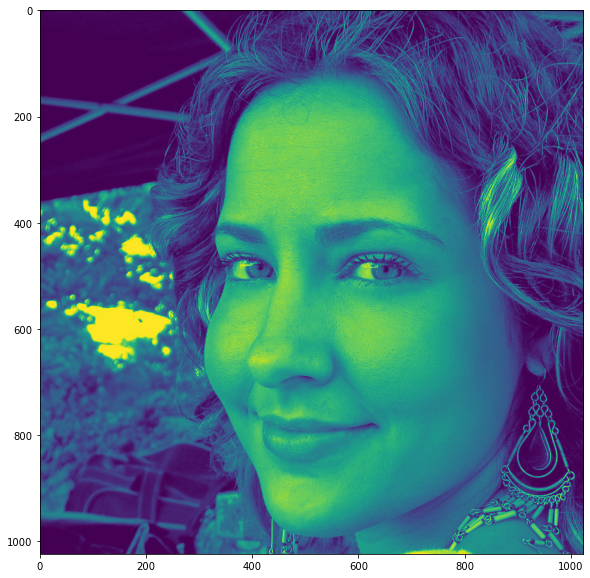

In [92]:
import matplotlib.image as mpimg
gray = cv2.cvtColor(mpimg.imread('../input/testingdatasets/2.jpg'), cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.25, 6)
print(faces)
plt.figure(figsize=(10,10))
#plt.imshow(mpimg.imread('../input/testimages/T0.jpg'))
plt.imshow(gray)
plt.show()

In [93]:
for (x, y, w, h) in faces:
    gray_face = gray[y : y+h, x : x+w]
    gray_norm = gray_face / 255
    original_shape = gray_face.shape
    face_resized = cv2.resize(gray_norm, (96, 96), interpolation = cv2.INTER_AREA)
    face_resized_copy = face_resized.copy()
    face_resized = face_resized.reshape(1, 96, 96, 1)
    keypoints = model.predict(face_resized)
    #Since we divided by image size during training, to get real coordinate values, it has to be multiplied
    keypoints = keypoints * 96
    print(keypoints)
    #color_face = frame[y : y+h, x : x+w]

[[67.20439  36.07286  28.336258 39.239925 46.2264   61.269516 48.234505
  90.23352 ]]


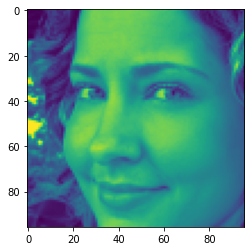

In [94]:
plt.imshow(face_resized_copy)

In [95]:
points = keypoints[0]
mask1 = np.zeros_like(face_resized_copy)

In [96]:
# for i in range(0, len(points), 2):
#     cv2.circle(face_resized_copy, (points[i], points[i+1]), 1,   (0,0, 0), 1)

for i in range(0, len(points), 2):
    cv2.circle(mask1, (points[i], points[i+1]), 1,   (255,255, 255), 1)

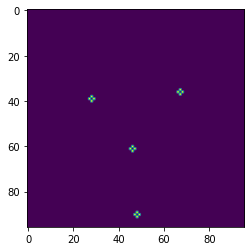

In [97]:
plt.imshow(mask1)

In [98]:
imgColorLE = cv2.GaussianBlur(mask1,(7,7),10)
imgColorLE_Final = cv2.addWeighted(face_resized_copy,1,imgColorLE,0.2,0)

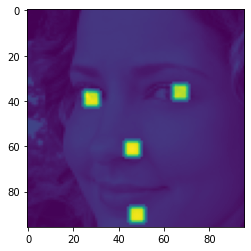

In [99]:
plt.imshow(imgColorLE_Final)

[[174 239 682 682]]


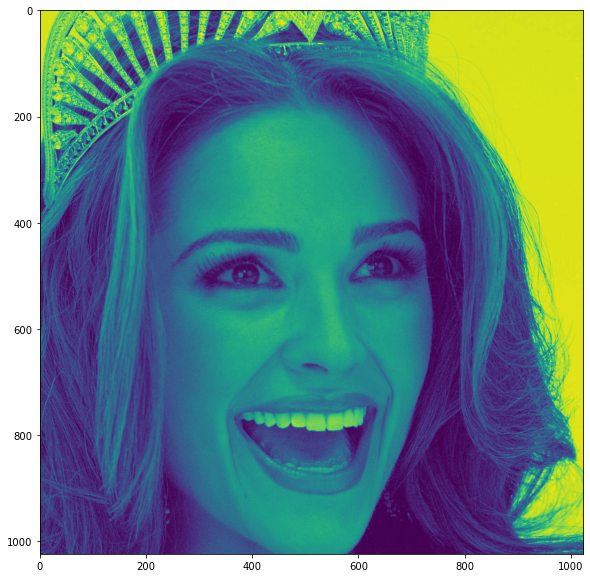

In [100]:
import matplotlib.image as mpimg
gray = cv2.cvtColor(mpimg.imread('../input/testimages/T0.jpg'), cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.25, 6)
print(faces)
plt.figure(figsize=(10,10))
#plt.imshow(mpimg.imread('../input/testimages/T0.jpg'))
plt.imshow(gray)
plt.show()

[[67.07593  37.319633 29.267864 38.649178 48.533478 62.832687 47.7572
  90.51477 ]]


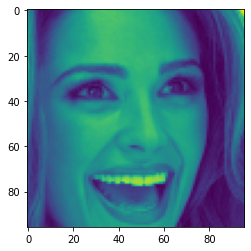

In [102]:
for (x, y, w, h) in faces:
    gray_face = gray[y : y+h, x : x+w]
    gray_norm = gray_face / 255
    original_shape = gray_face.shape
    face_resized = cv2.resize(gray_norm, (96, 96), interpolation = cv2.INTER_AREA)
    face_resized_copy = face_resized.copy()
    face_resized = face_resized.reshape(1, 96, 96, 1)
    keypoints = model.predict(face_resized)
    #Since we divided by image size during training, to get real coordinate values, it has to be multiplied
    keypoints = keypoints * 96
    print(keypoints)
    #color_face = frame[y : y+h, x : x+w]
points = keypoints[0]
mask1 = np.zeros_like(face_resized_copy)
for i in range(0, len(points), 2):
    cv2.circle(mask1, (points[i], points[i+1]), 1,   (255,255, 255), 1)
plt.imshow(face_resized_copy)

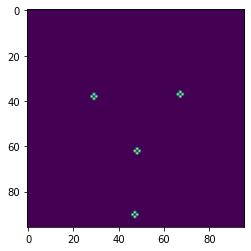

In [103]:
plt.imshow(mask1)

In [ ]:
imgColorLE = cv2.GaussianBlur(mask1,(7,7),10)
imgColorLE_Final = cv2.addWeighted(face_resized_copy,1,imgColorLE,0.2,0)
plt.imshow(imgColorLE_Final)